In [1]:
'''
Adapted code from https://github.com/jw15/kaggle_invasive_species/blob/master/src/invasive_cnn_224.py. 
'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.applications import ResNet50
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

# Runs code on GPU
os.environ["THEANO_FLAGS"] = "device=cuda, assert_no_cpu_op=True"


def load_images(root, test=False):
    labels = []
    file_paths_list = []
    test_names = []
    y = []
    shroom_names = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', "Russula", "Suillus", "Exidia", "Inocybe"]

    for (root,dirs,files) in os.walk(root):
        for filename in files:
            file_paths_list.append(os.path.join(root, filename).replace("\\", "/"))
            for i in shroom_names:
                if i in os.path.join(root, filename):
                    y.append(i)
                    break
    y = np.array(y)
    if test:
        return file_paths_list, y, test_names
    else:
        return file_paths_list, y

def _center_image(img, new_size=[256, 256]):
    row_buffer = (new_size[0] - img.shape[0]) // 2
    col_buffer = (new_size[1] - img.shape[1]) // 2
    centered = np.zeros(new_size + [img.shape[2]], dtype=np.uint8)
    centered[row_buffer:(row_buffer + img.shape[0]), col_buffer:(col_buffer + img.shape[1])] = img
    return centered

def resize_image_to_square(img, new_size=[512, 512]):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*new_size[1]/img.shape[0]),new_size[1])
    else:
        tile_size = (new_size[1], int(img.shape[0]*new_size[1]/img.shape[1]))
    return _center_image(cv2.resize(img, dsize=tile_size), new_size)

def crop_image(img, crop_size):
    row_buffer = (img.shape[0] - crop_size[0]) // 2
    col_buffer = (img.shape[1] - crop_size[1]) // 2
    return img[row_buffer:(img.shape[0] - row_buffer), col_buffer:(img.shape[1] - col_buffer)]

def process_images(file_paths_list, resize_new_size=[512,512], crop_size=[448, 448]):
    x = []
    for file_path in file_paths_list:
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize_image_to_square(img, new_size=resize_new_size)
        img = crop_image(img, crop_size=crop_size)
        x.append(img) 
    x = np.array(x)
    return x

def train_validation_split(X, y):
    X, y = resample(X, y, replace=False, n_samples = 4000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y)
    print('X_train: {} \ny_train: {} \nX_test: {} \ny_test: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, X_test, y_train, y_test 

def cnn_model_vgg16(x_train, x_test, y_train, y_test, batch_size=64, epochs=1, input_shape=(224,224,3)):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    add_model = Sequential()
    add_model.add(Dropout(0.7))
    add_model.add(GlobalAveragePooling2D())
    add_model.add(Dropout(0.3,  name = "dropout2"))
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(11, activation='softmax'))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    model.summary()

    #Data generator
    train_datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)
    train_datagen.fit(x_train)
    
    history = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[ModelCheckpoint('resnet.model', monitor='accuracy', save_best_only=True)]
    )
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(30)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    t_images = X_test.astype('float32')
    t_images /= 255.0
    predictions = model.predict(t_images)
    return predictions



In [2]:
if __name__ == '__main__':
    le = LabelEncoder()
    train_filepaths, train_y = load_images('shroom_photos')
    le.fit(train_y)
    train_y = le.transform(train_y)
    train_y = to_categorical(train_y, 11)
    train_images = process_images(train_filepaths, resize_new_size=[512,512], crop_size=[224, 224])

    X_train, X_test, y_train, y_test = train_validation_split(train_images, train_y)



X_train: (2800, 224, 224, 3) 
y_train: (2800, 11) 
X_test: (1200, 224, 224, 3) 
y_test: (1200, 11)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 485s 11s/step - loss: 2.0349 - accuracy: 0.3512 - val_loss: 80.1218 - val_accuracy: 0.0408
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.5084INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 476s 11s/step - loss: 1.4843 - accuracy: 0.5084 - val_loss: 35.4332 - val_accuracy: 0.0975
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.5647INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 467s 11s/step - loss: 1.2876 - accuracy: 0.5647 - val_loss: 66.4515 - val_accuracy: 0.1992
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 1.1475 - accuracy: 0.6045INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 444s 10s/step - loss: 1.1475 - accuracy: 0.6045 - val_loss: 5.2299 - val_accuracy: 0.1992
Epoch 5/30
43/43 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.6557INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 443s 10s/step - loss: 1.0035 - accuracy: 0.6557 - val_loss: 3.8237 - val_accuracy: 0.1525
Epoch 6/30
43/43 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.6955INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 441s 10s/step - loss: 0.8948 - accuracy: 0.6955 - val_loss: 2.3912 - val_accuracy: 0.1542
Epoch 7/30
43/43 [==============================] - 429s 10s/step - loss: 0.9015 - accuracy: 0.6937 - val_loss: 2.3464 - val_accuracy: 0.0800
Epoch 8/30
43/43 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.7189INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 447s 10s/step - loss: 0.7887 - accuracy: 0.7189 - val_loss: 4.9356 - val_accuracy: 0.1092
Epoch 9/30
43/43 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7719INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 441s 10s/step - loss: 0.6741 - accuracy: 0.7719 - val_loss: 4.3672 - val_accuracy: 0.1525
Epoch 10/30
43/43 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.7836INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 447s 10s/step - loss: 0.6421 - accuracy: 0.7836 - val_loss: 3.0986 - val_accuracy: 0.1075
Epoch 11/30
43/43 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.7979INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 462s 11s/step - loss: 0.5933 - accuracy: 0.7979 - val_loss: 3.5416 - val_accuracy: 0.0483
Epoch 12/30
43/43 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.8067INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 446s 10s/step - loss: 0.5805 - accuracy: 0.8067 - val_loss: 4.1276 - val_accuracy: 0.0850
Epoch 13/30
43/43 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.8308INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 460s 11s/step - loss: 0.5085 - accuracy: 0.8308 - val_loss: 3.6838 - val_accuracy: 0.1550
Epoch 14/30
43/43 [==============================] - 458s 11s/step - loss: 0.5650 - accuracy: 0.8158 - val_loss: 4.3772 - val_accuracy: 0.0800
Epoch 15/30
43/43 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8322INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 472s 11s/step - loss: 0.4879 - accuracy: 0.8322 - val_loss: 4.5669 - val_accuracy: 0.0792
Epoch 16/30
43/43 [==============================] - 439s 10s/step - loss: 0.4810 - accuracy: 0.8319 - val_loss: 4.1043 - val_accuracy: 0.0933
Epoch 17/30
43/43 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8472INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 455s 11s/step - loss: 0.4499 - accuracy: 0.8472 - val_loss: 3.9925 - val_accuracy: 0.1550
Epoch 18/30
43/43 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.8750INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 456s 11s/step - loss: 0.3770 - accuracy: 0.8750 - val_loss: 3.2332 - val_accuracy: 0.1725
Epoch 19/30
43/43 [==============================] - 439s 10s/step - loss: 0.4099 - accuracy: 0.8655 - val_loss: 4.2994 - val_accuracy: 0.2158
Epoch 20/30
43/43 [==============================] - 439s 10s/step - loss: 0.3827 - accuracy: 0.8688 - val_loss: 3.8784 - val_accuracy: 0.2658
Epoch 21/30
43/43 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8922INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 458s 11s/step - loss: 0.3108 - accuracy: 0.8922 - val_loss: 2.8110 - val_accuracy: 0.3383
Epoch 22/30
43/43 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9031INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 465s 11s/step - loss: 0.2822 - accuracy: 0.9031 - val_loss: 2.9469 - val_accuracy: 0.3958
Epoch 23/30
43/43 [==============================] - 444s 10s/step - loss: 0.3707 - accuracy: 0.8710 - val_loss: 2.0522 - val_accuracy: 0.4900
Epoch 24/30
43/43 [==============================] - 444s 10s/step - loss: 0.3052 - accuracy: 0.8999 - val_loss: 2.2432 - val_accuracy: 0.4850
Epoch 25/30
43/43 [==============================] - 443s 10s/step - loss: 0.2985 - accuracy: 0.8947 - val_loss: 3.1873 - val_accuracy: 0.4850
Epoch 26/30
43/43 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9200INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 464s 11s/step - loss: 0.2252 - accuracy: 0.9200 - val_loss: 2.1569 - val_accuracy: 0.5733
Epoch 27/30
43/43 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9265INFO:tensorflow:Assets written to: resnet.model\assets


INFO:tensorflow:Assets written to: resnet.model\assets


43/43 [==============================] - 465s 11s/step - loss: 0.2187 - accuracy: 0.9265 - val_loss: 4.9110 - val_accuracy: 0.3925
Epoch 28/30
43/43 [==============================] - 450s 10s/step - loss: 0.2373 - accuracy: 0.9203 - val_loss: 2.1043 - val_accuracy: 0.5583
Epoch 29/30
43/43 [==============================] - 448s 10s/step - loss: 0.2214 - accuracy: 0.9240 - val_loss: 2.9813 - val_accuracy: 0.4808
Epoch 30/30
43/43 [==============================] - 447s 10s/step - loss: 0.2355 - accuracy: 0.9221 - val_loss: 2.7364 - val_accuracy: 0.5958


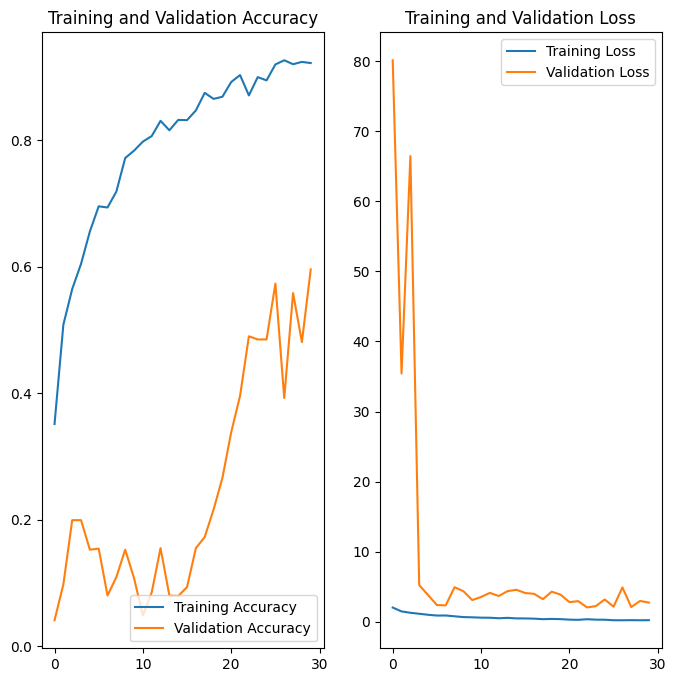

38/38 [==============================] - 44s 1s/step


In [3]:
predictions = cnn_model_vgg16(X_train, X_test, y_train, y_test, batch_size=64, epochs=30, input_shape=(224,224,3))
#sample_submission = pd.read_csv("sample_submission.csv")
#make_submission(sample_submission, test_names, predictions)